In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.rcParams['figure.figsize'] = (15, 8)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
df = pd.read_csv('TS_data.txt', sep=",", header=0, index_col=['DATE'], parse_dates=True)
df = df[['SOUID','Q_TG','TG']]
df.head()

,SOUID,Q_TG,TG
DATE,,,
1947-01-01,128124,0,-24
1947-01-02,128124,0,-35
1947-01-03,128124,0,-45
1947-01-04,128124,0,-127
1947-01-05,128124,0,-150


In [3]:
df['TG'] = df['TG']*0.1
df['week'] = df.index.isocalendar().week
df['month'] = df.index.month
df['timestep'] = list(range(len(df)))
df.head(50)

,SOUID,Q_TG,TG,week,month,timestep
DATE,,,,,,
1947-01-01,128124,0,-2.4,1,1,0
1947-01-02,128124,0,-3.5,1,1,1
1947-01-03,128124,0,-4.5,1,1,2
1947-01-04,128124,0,-12.7,1,1,3
1947-01-05,128124,0,-15.0,1,1,4
1947-01-06,128124,0,-15.8,2,1,5
1947-01-07,128124,0,-12.3,2,1,6
1947-01-08,128124,0,-13.8,2,1,7
1947-01-09,128124,0,-9.2,2,1,8


In [4]:
def plot_data_frame(df, title='Average temp over time', ylim=True):
    df.plot()
    plt.title(title)
    plt.ylabel('Temp')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

In [5]:
df_train = df['January 1955':'December 2010'].copy() # 'January 1955'
df_test = df['Jan 2011':].copy()

In [6]:
# df_train.tail()
# df_test.head()
# df_train.shape, df_test.shape

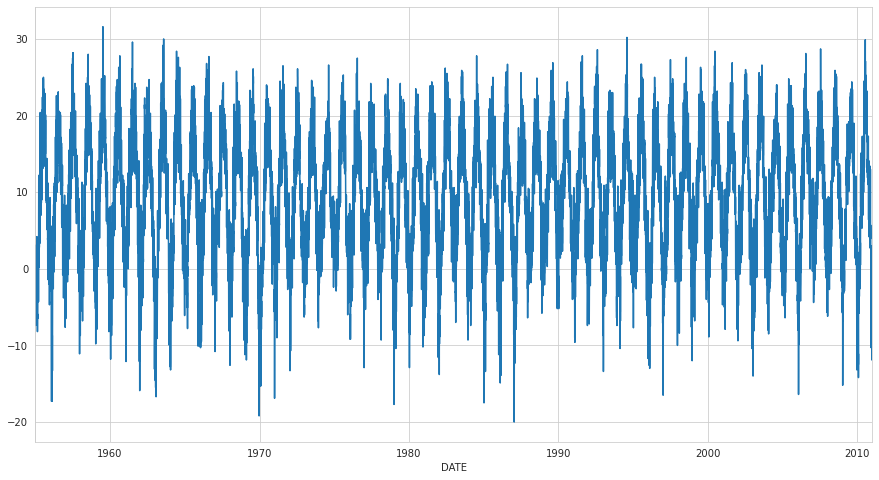

In [7]:
df_train['TG'].plot();

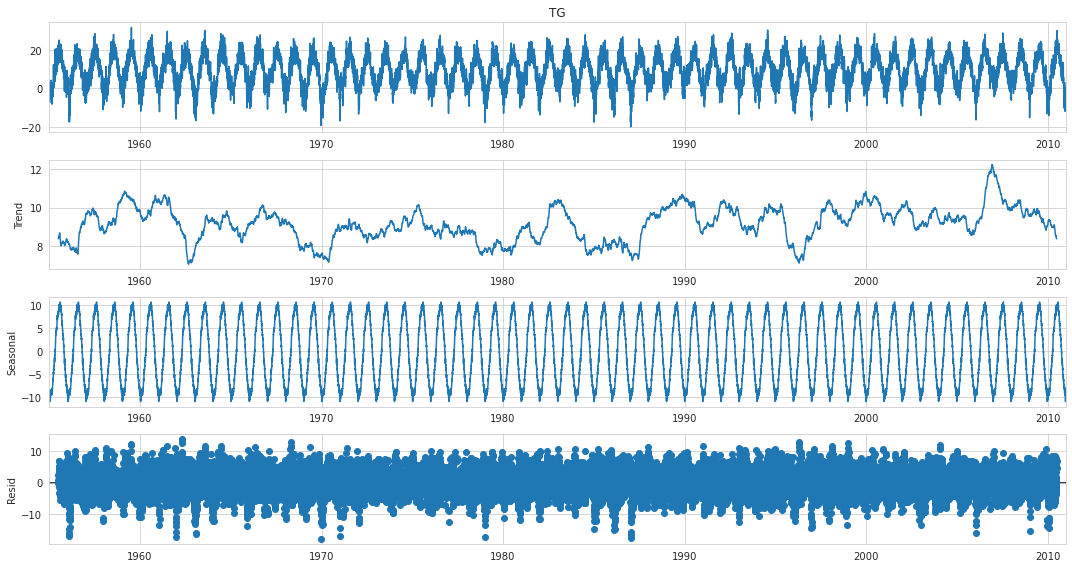

In [8]:
seasonality_year = seasonal_decompose(df_train['TG'], period = 365)
seasonality_year.plot()
None

In [9]:
# seasonality_week = seasonal_decompose(df_train['TG'], period = 52)
# seasonality_week.plot()
# None

In [10]:
seasonal_dummies = pd.get_dummies(df_train['month'], prefix='month_')
df_train = df_train.join(seasonal_dummies)
df_train.head()

,SOUID,Q_TG,TG,week,month,timestep,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
DATE,,,,,,,,,,,,,,,,,,
1955-01-01,128124,0,-1.9,52,1,2922,1,0,0,0,0,0,0,0,0,0,0,0
1955-01-02,128124,0,-2.0,52,1,2923,1,0,0,0,0,0,0,0,0,0,0,0
1955-01-03,128124,0,-2.6,1,1,2924,1,0,0,0,0,0,0,0,0,0,0,0
1955-01-04,128124,0,-3.9,1,1,2925,1,0,0,0,0,0,0,0,0,0,0,0
1955-01-05,128124,0,-7.1,1,1,2926,1,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# seasonal_dummies = pd.get_dummies(df_train['week'], prefix='week_')
# df_train = df_train.join(seasonal_dummies)
# df_train.head()

In [12]:
X = df_train.drop(['SOUID', 'Q_TG', 'TG', 'week', 'month'], axis=1)
y = df_train['TG']
# X.shape, y.shape # ((20454, 14), (20454,))
X.head()

,timestep,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
DATE,,,,,,,,,,,,,
1955-01-01,2922,1,0,0,0,0,0,0,0,0,0,0,0
1955-01-02,2923,1,0,0,0,0,0,0,0,0,0,0,0
1955-01-03,2924,1,0,0,0,0,0,0,0,0,0,0,0
1955-01-04,2925,1,0,0,0,0,0,0,0,0,0,0,0
1955-01-05,2926,1,0,0,0,0,0,0,0,0,0,0,0


In [13]:
y.head()

DATE
1955-01-01   -1.9
1955-01-02   -2.0
1955-01-03   -2.6
1955-01-04   -3.9
1955-01-05   -7.1
Name: TG, dtype: float64

In [14]:
# X = df_train.drop(['SOUID', 'Q_TG', 'TG', 'week', 'month'], axis=1)
# y = df_train['TG']
# # X.shape, y.shape # ((20454, 14), (20454,))
# X.head()

In [15]:
m = LinearRegression()
m.fit(X, y)
df_train['trend_and_seasonality'] = m.predict(X)
df_train.head()

,SOUID,Q_TG,TG,week,month,timestep,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,trend_and_seasonality
DATE,,,,,,,,,,,,,,,,,,,
1955-01-01,128124,0,-1.9,52,1,2922,1,0,0,0,0,0,0,0,0,0,0,0,-0.796423
1955-01-02,128124,0,-2.0,52,1,2923,1,0,0,0,0,0,0,0,0,0,0,0,-0.796383
1955-01-03,128124,0,-2.6,1,1,2924,1,0,0,0,0,0,0,0,0,0,0,0,-0.796344
1955-01-04,128124,0,-3.9,1,1,2925,1,0,0,0,0,0,0,0,0,0,0,0,-0.796305
1955-01-05,128124,0,-7.1,1,1,2926,1,0,0,0,0,0,0,0,0,0,0,0,-0.796266


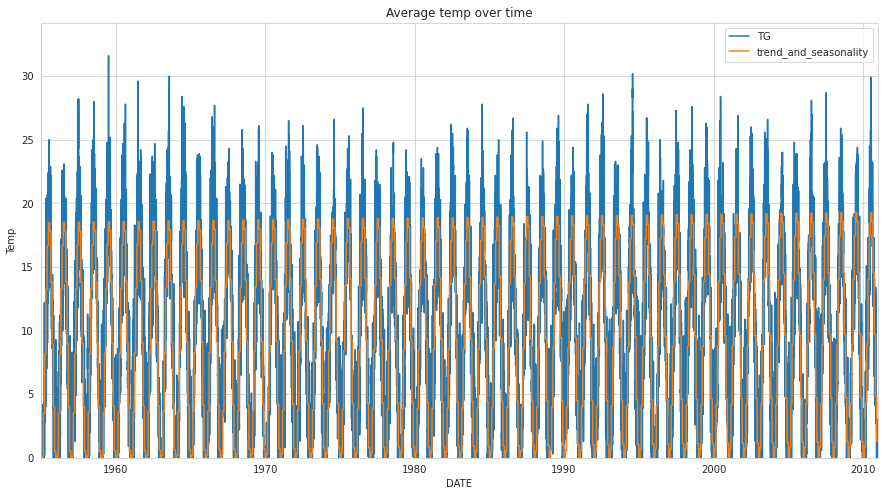

In [16]:
plot_data_frame(df_train[['TG', 'trend_and_seasonality']])

In [17]:
df_train['remainder'] = df_train['TG'] - df_train['trend_and_seasonality']
df_train.head()

,SOUID,Q_TG,TG,week,month,timestep,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,trend_and_seasonality,remainder
DATE,,,,,,,,,,,,,,,,,,,,
1955-01-01,128124,0,-1.9,52,1,2922,1,0,0,0,0,0,0,0,0,0,0,0,-0.796423,-1.103577
1955-01-02,128124,0,-2.0,52,1,2923,1,0,0,0,0,0,0,0,0,0,0,0,-0.796383,-1.203617
1955-01-03,128124,0,-2.6,1,1,2924,1,0,0,0,0,0,0,0,0,0,0,0,-0.796344,-1.803656
1955-01-04,128124,0,-3.9,1,1,2925,1,0,0,0,0,0,0,0,0,0,0,0,-0.796305,-3.103695
1955-01-05,128124,0,-7.1,1,1,2926,1,0,0,0,0,0,0,0,0,0,0,0,-0.796266,-6.303734


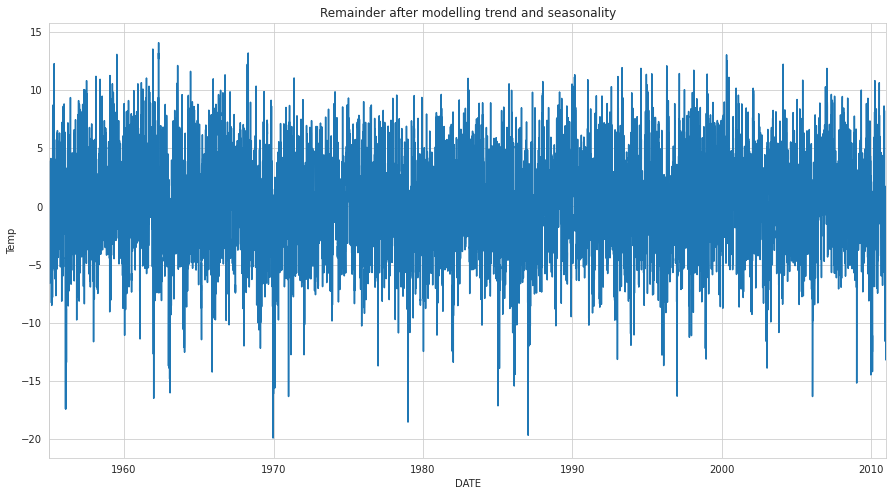

In [18]:
plot_data_frame(df_train['remainder'], title='Remainder after modelling trend and seasonality', ylim=False)

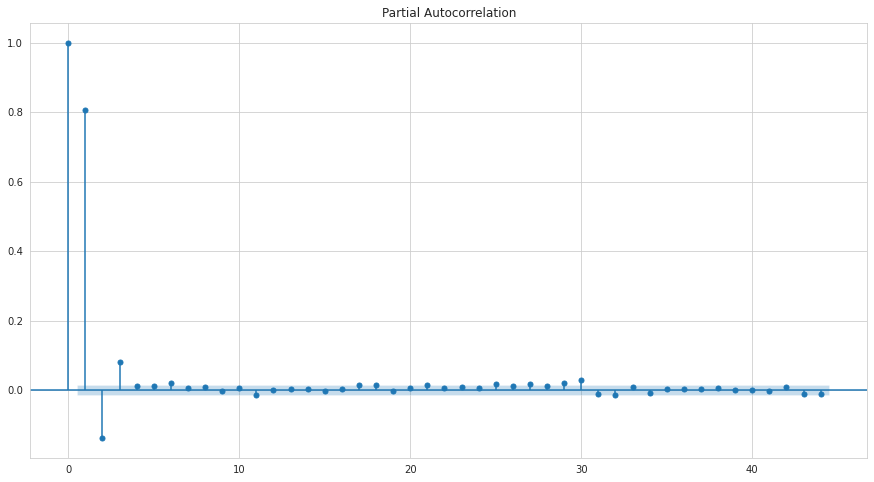

In [19]:
plot_pacf(df_train['remainder']); # 1 lag

In [20]:
model_sm = AutoReg(df_train['remainder'], lags=1).fit()

/home/mmuratardag/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [21]:
df_train['lag1'] = df_train['remainder'].shift(1)
df_train.dropna(inplace=True)
df_train.head()

,SOUID,Q_TG,TG,week,month,timestep,month__1,month__2,month__3,month__4,...,month__6,month__7,month__8,month__9,month__10,month__11,month__12,trend_and_seasonality,remainder,lag1
DATE,,,,,,,,,,,,,,,,,,,,,
1955-01-02,128124,0,-2.0,52,1,2923,1,0,0,0,...,0,0,0,0,0,0,0,-0.796383,-1.203617,-1.103577
1955-01-03,128124,0,-2.6,1,1,2924,1,0,0,0,...,0,0,0,0,0,0,0,-0.796344,-1.803656,-1.203617
1955-01-04,128124,0,-3.9,1,1,2925,1,0,0,0,...,0,0,0,0,0,0,0,-0.796305,-3.103695,-1.803656
1955-01-05,128124,0,-7.1,1,1,2926,1,0,0,0,...,0,0,0,0,0,0,0,-0.796266,-6.303734,-3.103695
1955-01-06,128124,0,-5.3,1,1,2927,1,0,0,0,...,0,0,0,0,0,0,0,-0.796226,-4.503774,-6.303734


In [22]:
X_full = df_train.drop(columns=['TG', 'SOUID', 'Q_TG', 'week', 'month', 'trend_and_seasonality', 'remainder'])
# X_full.head()
y_full = df_train['TG']
# y_full.head()

In [23]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)
df_train['predictions_full_model'] = m_full.predict(X_full)
df_train.head()

,SOUID,Q_TG,TG,week,month,timestep,month__1,month__2,month__3,month__4,...,month__7,month__8,month__9,month__10,month__11,month__12,trend_and_seasonality,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
1955-01-02,128124,0,-2.0,52,1,2923,1,0,0,0,...,0,0,0,0,0,0,-0.796383,-1.203617,-1.103577,-1.642159
1955-01-03,128124,0,-2.6,1,1,2924,1,0,0,0,...,0,0,0,0,0,0,-0.796344,-1.803656,-1.203617,-1.722774
1955-01-04,128124,0,-3.9,1,1,2925,1,0,0,0,...,0,0,0,0,0,0,-0.796305,-3.103695,-1.803656,-2.206497
1955-01-05,128124,0,-7.1,1,1,2926,1,0,0,0,...,0,0,0,0,0,0,-0.796266,-6.303734,-3.103695,-3.254574
1955-01-06,128124,0,-5.3,1,1,2927,1,0,0,0,...,0,0,0,0,0,0,-0.796226,-4.503774,-6.303734,-5.834465


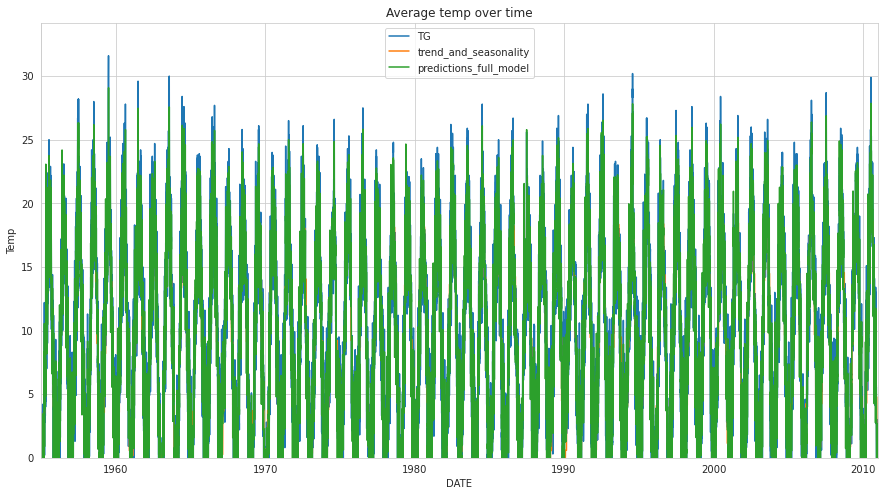

In [24]:
plot_data_frame(df_train[['TG', 'trend_and_seasonality', 'predictions_full_model']])

In [25]:
ts_split = TimeSeriesSplit(n_splits=5)
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=ts_split, n_jobs = 7)
result.mean()

0.912703485108398